In [1]:
import os

os.chdir("C:/Users/ac135963/Nextcloud/Projekte/sampy")

from Helper import *
from World import *
from Visualizer import *
from Agent import *
from Cell import *

import statistics

class Heating_Agent(Agent):
    desire = 0
    loss_rate = 0.125
    tolerance = 0.01
    adjustment_size = 0.1

    def __init__(self,
                 desire,
                 output,
                 worldstate,
                 input,
                 loss_rate,
                 ):

        Agent.__init__(self)

        # desired worldstate value / input value
        self.desire = desire

        # value of performed action
        self.output = output

        # worldstate in the world of this agent
        self.worldstate = worldstate

        # subjectively perceived world state
        self.input = input

        # result of last evaluation
        self.evaluation_result = str

        # dict of lists with neighbor-groups
        self.neighbors = {}

        # number
        self.n_borders = int

        # loss rate per border
        #self.loss_rate = loss_rate

        self.data = {
            "tick": [],
            "desire": [],
            "worldstate": [],
            "input": [],
            "output": [],
            "evaluation_result": [],
            "n_borders": [],
            "n_neighbors": [],
            "x_pos": [],
            "y_pos": []}

    def find_all_neighbors_on_neighbor_cells(self):
        self.neighbors = []
        for cell in self.residence_cell.neighbor_cells:
            self.neighbors.extend(list(cell.dict_of_residents.values()))
        
        
        #self.neighbors = [len(cell.residents) 
        #                  for cell in self.residence_cell.neighbor_cells]
        self.n_borders = len(self.neighbors)
       


    def evaluate_input(self):
        """
        evaluates the perceived worldstate/input value
        changes Agent.evaluation_result to either "too high", "too low" or "perfect"
        Input: Agent.input; Agent.desire
        Output: Agent.evaluation_result
        """

        if self.input > self.desire + self.tolerance:
            self.evaluation_result = "too high"

        elif self.input < self.desire - self.tolerance:
            self.evaluation_result = "too low"

        else:
            self.evaluation_result = "perfect"


    def set_output(self, output_min=None, output_max=None):
        """
        sets/adjusts the output depending on the evaluation of the input
        Input: Agent.evaluation_result
        Output: Agent.output
        """

        output = self.output

        if self.evaluation_result == "perfect":
            pass
        else:
            adjustment = random.uniform(0, self.adjustment_size)
            # wenn adjustment sehr klein, dann entstehen die muster nicht.

            if self.evaluation_result == "too high":
                output -= adjustment
            else:
                output += adjustment

        # keep output within boundaries
        if output_min != None:
            if output < output_min:
                output = output_min

        if output_max != None:
            if output > output_max:
                output = output_max

        self.output = output


    def calculate_worldstate_and_input(self, interdependence_structure):

        # input_i = worldstate_i = output_i * (1 - p) + output_j * p
        if interdependence_structure == "local_exchange":

            own_contribution = self.output * (1 - self.loss_rate * self.n_borders)
            contribution_of_neighbors = sum([neigh.loss_rate * neigh.output for neigh in self.neighbors])
            self.worldstate = own_contribution + contribution_of_neighbors

            self.input = self.worldstate

        # input_i = worldstate_i = output_i + output_j * p
        elif interdependence_structure == "local_giving":

            own_contribution = self.output
            contribution_of_neighbors = sum([neigh.loss_rate * neigh.output for neigh in self.neighbors])
            self.worldstate = own_contribution + contribution_of_neighbors

            self.input = self.worldstate


        elif interdependence_structure == "diffusion":
            own_contribution = self.output

            contribution_of_neighbors = sum([neigh.loss_rate * neigh.worldstate for neigh in self.neighbors])

            self.worldstate = own_contribution + contribution_of_neighbors

            self.input = self.worldstate * (1 - self.loss_rate)








pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
world = World(50, 50)
world.create_grid()

# Agenten-Population erstellen
world.agents.update({"agents_1": [] })

for cell in world.grid_as_flat_list:
    
    agent = Heating_Agent(0,0,0,0,0.12475)
    agent.desire += random.randint(-1,1)

    world.agents["agents_1"].append(agent)
    
    cell.neighbor_cells = cell.find_arounding_cells(
        "neumann", 
        world.len_x_grid_dim, 
        world.len_y_grid_dim, 
        world.grid_as_matrix,
    )
    
world.place_agents_on_grid(world.agents["agents_1"])

# Nachbarn der Agenten finden
for agent in world.agents["agents_1"]:
    agent.find_all_neighbors_on_neighbor_cells()

# Mittleren Agenten manipulieren
#world.grid_as_flat_list[int(len(world.grid_as_flat_list) / 2)].main_resident.desire += 10
#world.grid_as_flat_list[int(len(world.grid_as_flat_list) / 4)].main_resident.desire -= 10

def animate_heating():   
    
    agents = world.agents["agents_1"]
    random.shuffle(agents)
    
    for focal_agent in agents:
        focal_agent = random.choice(world.agents["agents_1"])
        focal_agent.calculate_worldstate_and_input("local_exchange")
        focal_agent.evaluate_input()
        focal_agent.set_output(output_min=-50, output_max=50)

        desire_output_matrix = []
        for row in world.grid_as_matrix:
            desire_output_row = []
            for cell in row:
                desire_output_row.append(cell.main_resident.output)
            desire_output_matrix.append(desire_output_row)
    return desire_output_matrix

10000
10000


Traceback (most recent call last):
  File "C:\Users\ac135963\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\ac135963\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py", line 953, in _start
    self._init_draw()
  File "C:\Users\ac135963\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "C:\Users\ac135963\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py", line 1755, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-7-2769b1325038>", line 9, in animate_func
    im.set_array(animate_heating())
TypeError: animate_heating() missing 1 required positional argument: 'i'


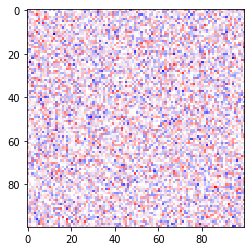

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig, ax = plt.subplots()

im = ax.imshow(animate_heating(0), cmap = "bwr")

def animate_func(i):
    im.set_array(animate_heating())
    return im



anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               interval = 1, # in ms
                               )

plt.show()

<IPython.core.display.Javascript object>


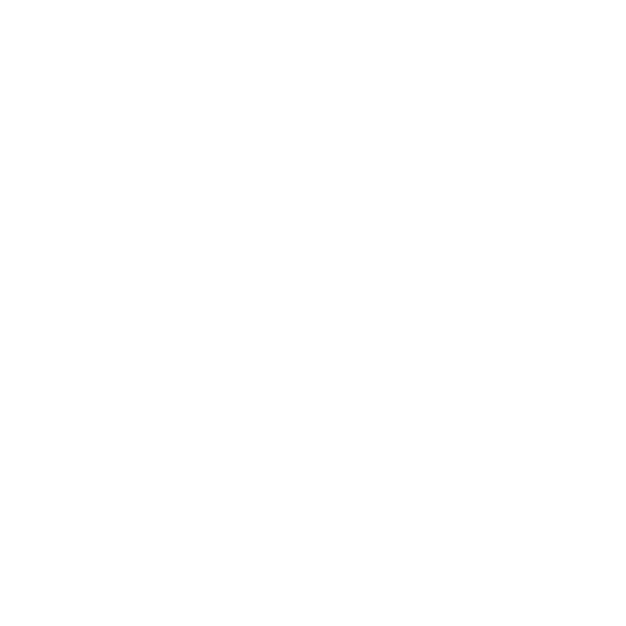

NameError: name 'snapshots' is not defined

In [8]:
import numpy as np
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(7,7) )

a = snapshots[0]
im = plt.imshow(a, 
                interpolation='none', 
                #aspect='auto', 
                vmin=-50, 
                vmax=50,
                #cmap = "gist_rainbow"
                #cmap = "bwr",
                cmap = "coolwarm"
                #cmap=plt.get_cmap("RdBu"),
               )




def animate_func(i):
    im.set_array(desire_output_data[i])
    return [im]


anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(desire_output_data),
                               interval = 1, # in ms
                               )

plt.show()

In [ ]:
HTML(anim.to_jshtml())